In [3]:
# As before, make sure gensim is installed
# Usually pip install gensim, but YMMV

from gensim.models import word2vec,doc2vec
from gensim.models import KeyedVectors
from gensim import utils

In [4]:
# Each document is in a separate text file
# Use the glob module to work with file names
import glob 
# smart_open helps with streaming data from files
import smart_open

In [8]:
# Write a function to handle the pre-processing 
# We will write this as a generator so it streams the data to conserve memory

def read_corpus(globexpr, blocksize=2):
    # Read and process all files that match the provided glob expression
    # assumes all text files are encoded as iso-8859-1
    for fname in glob.iglob(globexpr, recursive=True):
        with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
            block = []
            for i, line in enumerate(f):
                if i % blocksize != blocksize - 1: 
                    cleanline = utils.simple_preprocess(line)
                    if not cleanline: continue
                    block = block + cleanline
                else:
                    #yield doc2vec.TaggedDocument(block, ["%s:%s" % (fname,i//blocksize)])
                    yield doc2vec.TaggedDocument(block, [fname])
                    block = []

# Make a list of all the files from NIPS 2005
docs = [doc for doc in read_corpus("nipstxt/nips*/*.txt",blocksize=3)]

# Check to see that the output looks sensible
print(docs[20:22])

[TaggedDocument(words=['describe', 'the', 'mid', 'term', 'transient', 'activity', 'markovian', 'systems', 'that', 'tend', 'to', 'silence', 'with', 'high', 'probability', 'in', 'the', 'long', 'run'], tags=['nipstxt/nips00/0192.txt']), TaggedDocument(words=['iring', 'rates', 'as', 'such', 'rates', 'would', 'be', 'zero', 'in', 'most', 'our', 'cases', 'in', 'the', 'ollowing', 'models', 'time', 'will', 'proceed', 'in', 'discrete', 'steps'], tags=['nipstxt/nips00/0192.txt'])]


In [6]:
# Train a Doc2Vec model using the extracted documents
# (You can skip this cell if you've already saved the model previously)
model = doc2vec.Doc2Vec(docs, alpha=.025, min_alpha=.025, workers=4, window=6, min_count=5, iter=7, dm=1, dbow_words=1)

print(model)
model.save('nips.model.small')

Doc2Vec(dm/m,d100,n5,w6,mc5,s0.001,t4)


In [5]:
# Load the model from a file
model = doc2vec.Doc2Vec.load('nips.model.small')
print(model)

Doc2Vec(dm/m,d100,n5,w6,mc5,s0.001,t4)


In [39]:
# Find the terms most similar to "svm"  
model.most_similar(positive=['step'], negative=[], topn=10)

# What do we expect to see?
# Note: Here we are using the word2vec model, not the doc2vec model.  
# Remember word2vec vectors are an input to doc2vec.



[('steps', 0.6051098108291626),
 ('iteration', 0.5607196092605591),
 ('epoch', 0.4857795834541321),
 ('subsection', 0.47750017046928406),
 ('sweep', 0.45312538743019104),
 ('recursion', 0.4438837170600891),
 ('recursions', 0.44324538111686707),
 ('minute', 0.4330310821533203),
 ('stage', 0.4324946105480194),
 ('keystroke', 0.4307841658592224)]

In [9]:
# Build a dictionary so we can look up the original documents by tag 
# (I'm not sure why Doc2Vec doesn't provide this for you, but it doesn't seem to.)
docdict = {}
for i, d in enumerate(docs):
    key = d.tags[0]
    val = docdict.get(key, [])
    val.append(d)
    docdict[key] = val

In [10]:
query = "2D materials used in quantum computing".split()
print("most similar to '", query, "'")
targetvec = model.infer_vector(query)
#print(targetvec)
for tag, sim in model.docvecs.most_similar([targetvec], topn=3):
    #print(tag, sim)
    #print(model.docvecs[tag])
    snippet = "\n".join([" ".join(d.words) for d in docdict[tag]])
    print("MATCH", tag, sim, "\n", snippet, "\n")

most similar to ' ['2D', 'materials', 'used', 'in', 'quantum', 'computing'] '
MATCH nipstxt/nips10/0280.txt 0.4887927174568176 
 boltzmann machine learning using mean field theory and linear response correction
department of biophysics university of nijmegen geert grooteplein
rodriguez instituto de ingenieria del conocimiento departamento de ingenieria informs tica
abstract we present new approximate learning algorithm for boltzmann
second order in the weights the linear response correction to the correlations is given by the hessian of the gibbs free energy the
of neurons we compare the performance of the exact bm learning algorithm with first order weiss mean field theory and second
connected ising spin glass model on neurons we conclude that the method works well for paramagnetic problems the tap
theory both for paramagnetic and spin glass problems and that the inclusion of diagonal weights improves the weiss approximation
introduction boltzmann machines bms are networks of binary n

In [80]:
model.predict_output_word(["hamilton"])

[('hamilton', 0.12619615),
 ('university', 0.038542304),
 ('oh', 0.038114462),
 ('van', 0.0131783),
 ('phys', 0.012615132),
 ('edu', 0.0083096744),
 ('planck', 0.0065921266),
 ('cowan', 0.0061705513),
 ('der', 0.0058846357),
 ('japan', 0.0053933854)]

In [12]:
from sklearn import linear_model
import numpy as np


import re
yearpatt = 'nips(\d\d)'
#paperpatt = '(\d\d\d\d)'
years = [int(re.search(yearpatt, key).groups(0)[0]) for key in docdict.keys()]

regr = linear_model.LinearRegression()

X = model.docvecs.doctag_syn0
Y = np.array(years)

N = len(X)
split = 9*N//10
indices = np.random.permutation(X.shape[0])
training_idx, test_idx = indices[:split], indices[split:]


trainX, testX = X[training_idx], X[test_idx]
trainY, testY = Y[training_idx], Y[test_idx]

regr.fit(trainX, trainY)

predictY = regr.predict(testX)

residuals = predictY - testY

RSE = np.sqrt(sum((residuals**2/N)))

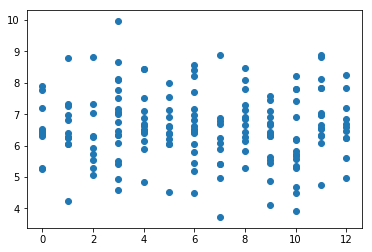

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.scatter(testY, predictY)